In [1]:
import cartopy.crs as ccrs
import datetime
import G211
import logging
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, ListedColormap
%matplotlib inline
from metpy.units import units
from ml_functions import get_glm
import nclcmaps
import numpy as np
import os
from scipy.ndimage import gaussian_filter
from statisticplot import make_map
import xarray

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

2023-09-26 11:08:05.187822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 11:08:05.760531: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
rptdist = 20
twin = 1
ifile = f"GLM/longterm_average.glm_{rptdist}km_{twin}hr.nc"
ifile2 = f"wbug_lightning/flash.{rptdist}km_30min.nc"

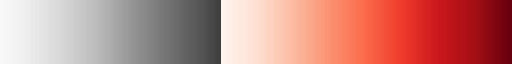

In [3]:
# map projection
map_crs = G211.g211
makemapkw = dict( projection=map_crs, scale=1.3, draw_labels=False)

test = nclcmaps.colors['MPL_Greys'][6:-25:] + nclcmaps.colors['MPL_Reds']
cmap = ListedColormap(test, "GreysReds")
n = 23 if rptdist == 40 else 10
norm = BoundaryNorm(range(n), ncolors=cmap.N, clip=True)
cmap

### lightning longterm average

2023-09-26 11:08:37,578 made GLM/longterm_average.glm_20km_1hr.png


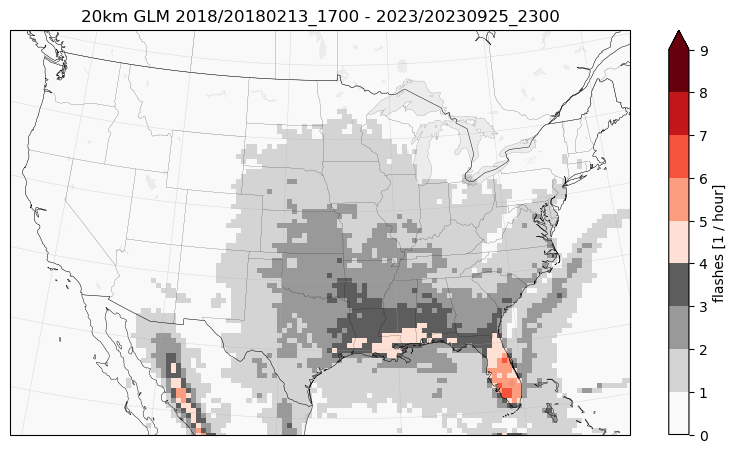

In [4]:
ds = xarray.open_dataset(ifile)
# history attribute contains the NCO command that created this netCDF file
# The NCO command contains a list of files that went into this file. 
ifiles = ds.attrs["nco_input_file_list"].split()

time_range = " - ".join([ifiles[0][:18],ifiles[-1][:18]])
glm_tmin = datetime.datetime.strptime(min(ifiles)[5:18], '%Y%m%d_%H%M')
glm_tmax = datetime.datetime.strptime(max(ifiles)[5:18], '%Y%m%d_%H%M')

fig, ax = make_map(**makemapkw)
ds = ds / (twin * units.hour)
sc = ds["flashes"].plot(x="lon", y="lat",  cmap=cmap, transform=ccrs.PlateCarree(), ax=ax, 
                        norm=norm, cbar_kwargs={"shrink":0.75})
ax.set_title(f"{rptdist}km GLM {time_range}")
base, ext = os.path.splitext(ifile)
ofile = base + ".png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")
del(ds.attrs["nco_input_file_list"])
glm = ds

In [5]:
glm

Magnitude,[[[0.0 0.0 0.0 ... 0.2452017366886139 0.21833142638206482 0.2965534031391144] [0.0 0.0 0.0 ... 0.11540346592664719 0.09139170497655869 0.19883207976818085] [0.0 0.0 0.0 ... 0.14276380836963654 0.09563867747783661 0.21722884476184845] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]]
Units,1/hour


In [6]:
logging.info(f"open wbug {ifile2}")
wb = xarray.open_dataset(ifile2)
wb = wb.sel(time_coverage_start=slice(glm_tmin,glm_tmax))
dt = wb.time_coverage_start.diff(dim="time_coverage_start").median()
assert dt.dt.seconds == 1800
wb = wb * 2 / units.hour # per hour instead of half-hour
fmt="%Y%m%d %H:%M"
tmin = wb.time_coverage_start.min().dt.strftime(fmt)
tmax = wb.time_coverage_start.max().dt.strftime(fmt)

title = f"[{tmin.data},{tmax.data}]"

logging.info(f"average {wb.time_coverage_start.size} times {title}")
wb = wb.mean(dim="time_coverage_start")
logging.info("done")

2023-09-26 11:08:37,933 open wbug wbug_lightning/flash.20km_30min.nc
2023-09-26 11:21:35,990 average 92234 times [20180213 17:00,20230831 23:30]
2023-09-26 11:24:04,595 done


2023-09-26 11:24:06,771 made GLM/longterm_average.glm_20km_1hr.png


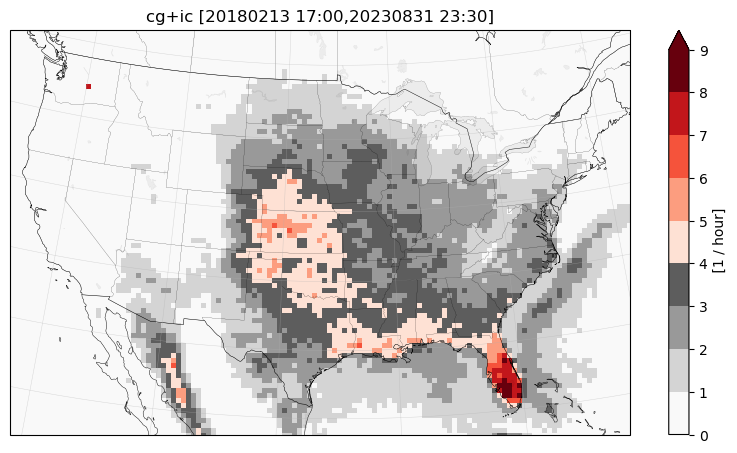

In [7]:
fig, ax = make_map(**makemapkw)
sc = (wb.cg+wb.ic).plot(x="lon", y="lat",  cmap=cmap, transform=ccrs.PlateCarree(), 
                        norm=norm, cbar_kwargs={"shrink":0.75})
ax.set_title(f"cg+ic {title}")

base, ext = os.path.splitext(ifile)
ofile = base + ".png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")

In [8]:
# Merge GLM and WxBug Datasets
# lat/lons are a little different (within machine precision)
ds = glm.squeeze().drop("time").merge(wb, compat="override")

In [9]:
levels = [10, 50 , 75, 90, 110, 133, 200, 1000]
sigma = 2.5

In [10]:
def ratio_plot(r, title, ofile):
    fig, ax = make_map(**makemapkw)
    CS = r.plot(x="lon", y="lat", transform=ccrs.PlateCarree(), ax=ax, 
                norm=colors.LogNorm(vmin=min(levels), vmax=max(levels)), cmap='RdBu_r',
               cbar_kwargs={"shrink":0.75})
    r.data = gaussian_filter(r.data, sigma)
    CS = r.plot.contour(x="lon", y="lat", transform=ccrs.PlateCarree(), levels=levels, colors="0.2", ax=ax)
    ax.clabel(CS)
    ax.set_title(title)
    fig.savefig(ofile)
    logging.warning(f"made {ofile}")

2023-09-26 11:24:09,380 made GLM/longterm_average.glm_20km_1hr.GLMWxBugratio.png


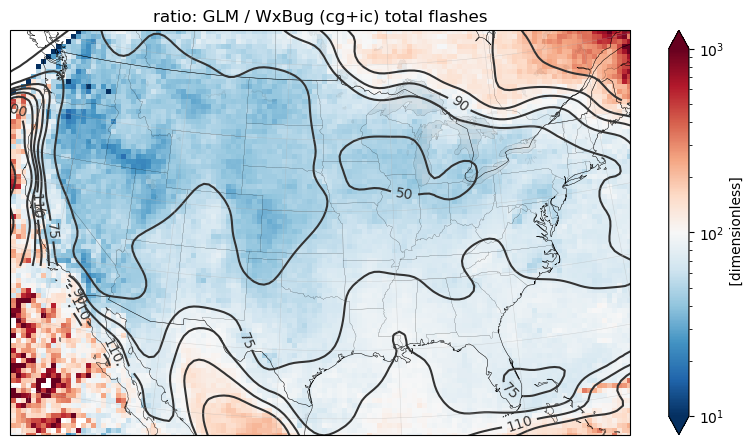

In [11]:
r = ds.flashes / (ds.cg + ds.ic)
ratio_plot(r*100, "ratio: GLM / WxBug (cg+ic) total flashes", base + ".GLMWxBugratio.png")

2023-09-26 11:24:10,500 made GLM/longterm_average.glm_20km_1hr.GLMICratio.png


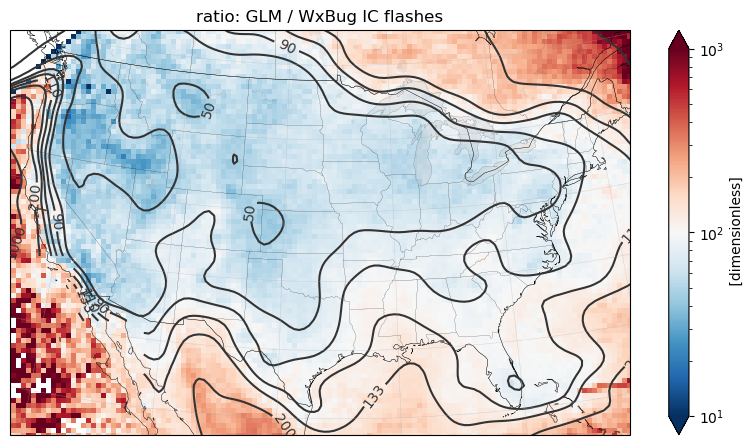

In [12]:
r = ds.flashes / ds.ic
ratio_plot(r*100, "ratio: GLM / WxBug IC flashes", base + ".GLMICratio.png")

In [13]:
time_space_window = (twin, rptdist)
glmbin = get_glm(time_space_window, start=glm_tmin, end=glm_tmax)

2023-09-26 11:24:10,961 get_glm: time/space window 1/20
2023-09-26 11:24:10,964 open /glade/scratch/ahijevyc/temp/all.glm_20km_1hr.nc for GLM flashes
2023-09-26 11:24:11,247 trim GLM to time window slice(datetime.datetime(2018, 2, 13, 17, 0), datetime.datetime(2023, 9, 25, 23, 0), None)
2023-09-26 11:24:11,265 Store in new DataArray flashes_20km_1hr


2023-09-26 11:24:54,793 made 10+flashes_20km_1hr.png


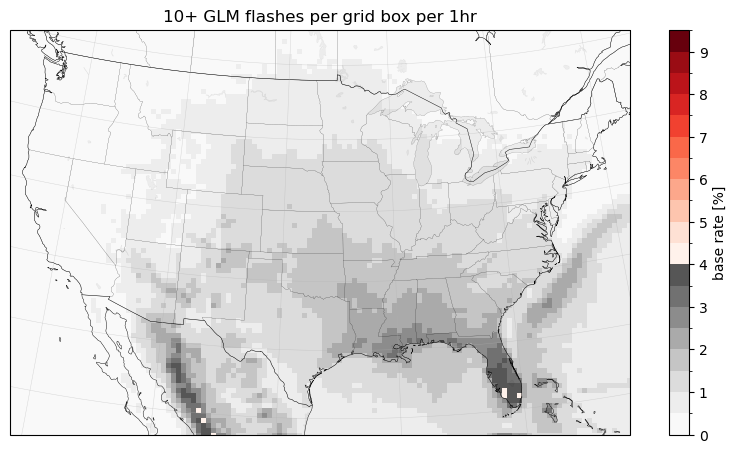

In [14]:
o_thresh = 10
twin = 1
norm = BoundaryNorm(np.arange(0,10.,0.5), ncolors=cmap.N, clip=True)

fig, ax = make_map(**makemapkw)
var = f"flashes_{rptdist}km_{twin}hr"
base_rate_glm = ((glmbin[var] >= o_thresh)*100).mean(dim="valid_time")
base_rate_glm.name = "base rate [%]"
base_rate_glm.plot(x="lon", y="lat", ax=ax, cmap=cmap, 
                        norm=norm, transform=ccrs.PlateCarree(), 
                        cbar_kwargs={"shrink":0.75})
ax.set_title(f"{o_thresh}+ GLM {var.replace(f'_{rptdist}km',' per grid box').replace('_',' per ')}")
ofile = f"{o_thresh}+{var}.png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")

In [15]:
wbugdir="wbug_lightning"
wbug = xarray.open_dataset(os.path.join(wbugdir, f"flash.{rptdist}km_30min.nc"))
wbug = wbug.rename(dict(time_coverage_start="valid_time"))
logging.info(f"valid_time slice({glm_tmin},{glm_tmax})")
wbug = wbug.sel(valid_time=slice(glm_tmin, glm_tmax))
ltg_sums=xarray.Dataset()
for t in [1,2,4]:
    # sum counts in 30-minute blocks
    # debug with ~ahijevyc/wbug_sum_time_window.ipynb
    logging.info(f"sum weatherbug flashes in {t}hr time window")
    ltg_sum = wbug.rolling(valid_time=t*2, center=True).sum()
    # Append rptdist and twin strings to ["cg","ic"] variable names.
    name_dict = {s: f"{s}_{rptdist}km_{t}hr" for s in ["cg","ic"]}
    logging.info(f"rename {name_dict}")
    ltg_sum = ltg_sum.rename(name_dict)
    logging.info(ltg_sum.mean())
    ltg_sums = ltg_sums.assign(ltg_sum)

2023-09-26 11:24:55,466 valid_time slice(2018-02-13 17:00:00,2023-09-25 23:00:00)
2023-09-26 11:24:55,470 sum weatherbug flashes in 1hr time window
2023-09-26 11:45:07,068 rename {'cg': 'cg_20km_1hr', 'ic': 'ic_20km_1hr'}
2023-09-26 11:51:04,215 <xarray.Dataset>
Dimensions:      ()
Data variables:
    cg_20km_1hr  float64 0.1642
    ic_20km_1hr  float64 0.5224
2023-09-26 11:51:04,865 sum weatherbug flashes in 2hr time window
2023-09-26 12:23:23,484 rename {'cg': 'cg_20km_2hr', 'ic': 'ic_20km_2hr'}
2023-09-26 12:30:24,204 <xarray.Dataset>
Dimensions:      ()
Data variables:
    cg_20km_2hr  float64 0.3284
    ic_20km_2hr  float64 1.045
2023-09-26 12:30:24,338 sum weatherbug flashes in 4hr time window
2023-09-26 13:11:41,186 rename {'cg': 'cg_20km_4hr', 'ic': 'ic_20km_4hr'}
2023-09-26 13:21:15,553 <xarray.Dataset>
Dimensions:      ()
Data variables:
    cg_20km_4hr  float64 0.6568
    ic_20km_4hr  float64 2.09


2023-09-26 13:38:41,918 made 10+cg.ic_20km_1hr.png


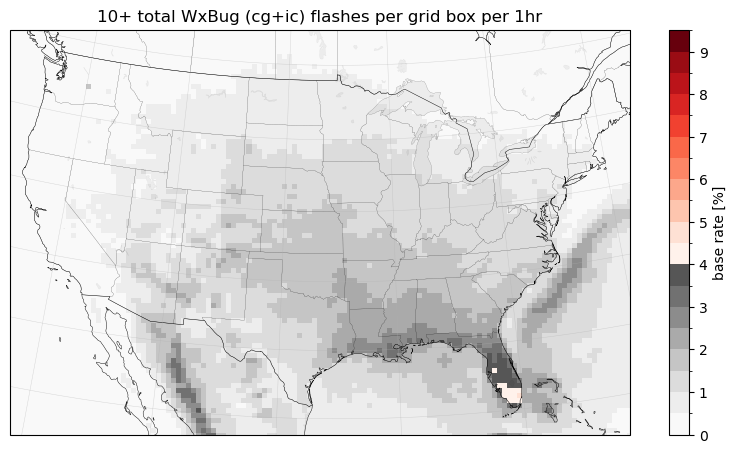

In [16]:
fig, ax = make_map(**makemapkw)
wbug = ltg_sums[f"cg_{rptdist}km_{twin}hr"] + ltg_sums[f"ic_{rptdist}km_{twin}hr"]
base_rate_wb = ((wbug >= o_thresh) * 100).mean(dim="valid_time")
base_rate_wb.name = "base rate [%]"
base_rate_wb.plot(
    x="lon",
    y="lat",
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"shrink": 0.75},
)
ax.set_title(
    f"{o_thresh}+ total WxBug (cg+ic) {var.replace(f'_{rptdist}km',' per grid box').replace('_',' per ')}"
)
ofile = f"{o_thresh}+cg.ic_{rptdist}km_{twin}hr" + ".png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")

2023-09-26 13:38:43,730 made 10+flashes_20km_1hr.GLM-WxBugratio.png


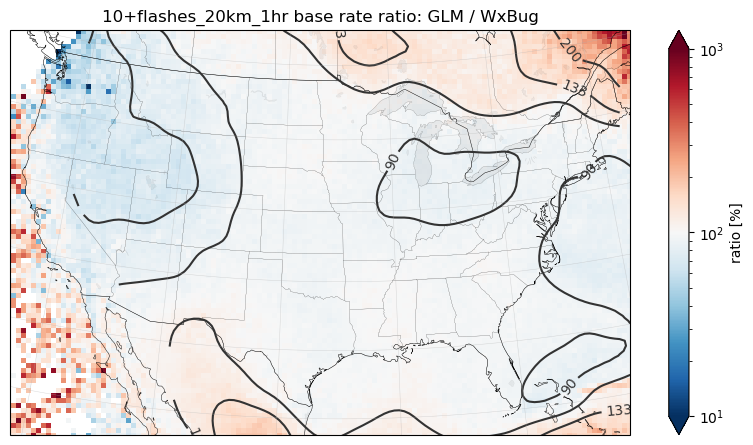

In [17]:
# .values to prevent lat and lon coordinates from going 
# away when dividing (they're slightly different)
r = base_rate_glm / base_rate_wb.values
r.name = "ratio [%]"
ratio_plot(
    r * 100,
    f"{o_thresh}+{var} base rate ratio: GLM / WxBug",
    f"{o_thresh}+{var}.GLM-WxBugratio.png",
)

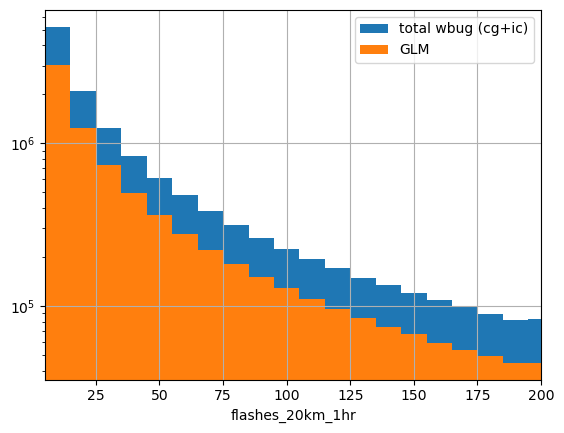

In [18]:
fig, ax = plt.subplots()
wbug.plot.hist(ax=ax,yscale="log",bins=range(5,210,10),xlim=(5,200), label="total wbug (cg+ic)")
glmbin[var].plot.hist(ax=ax, yscale="log",bins=range(5,210,10),xlim=(5,200), label="GLM")
ax.legend()
ax.grid()